# Detect data bias with Amazon SageMaker Clarify

# Terminology
https://docs.aws.amazon.com/sagemaker/latest/dg/clarify-detect-data-bias.html

* **Bias**: 
An imbalance in the training data or the prediction behavior of the model across different groups, such as age or income bracket. Biases can result from the data or algorithm used to train your model. For instance, if an ML model is trained primarily on data from middle-aged individuals, it may be less accurate when making predictions involving younger and older people.

* **Bias metric**: 
A function that returns numerical values indicating the level of a potential bias.

* **Bias report**:
A collection of bias metrics for a given dataset, or a combination of a dataset and a model.

* **Label**:
Feature that is the target for training a machine learning model. Referred to as the observed label or observed outcome.

* **Positive label values**:
Label values that are favorable to a demographic group observed in a sample. In other words, designates a sample as having a positive result.

* **Negative label values**:
Label values that are unfavorable to a demographic group observed in a sample. In other words, designates a sample as having a negative result.

* **Facet**:
A column or feature that contains the attributes with respect to which bias is measured.

* **Facet value**:
The feature values of attributes that bias might favor or disfavor.

# Pretraining Bias Metrics
https://docs.aws.amazon.com/sagemaker/latest/dg/clarify-measure-data-bias.html

* **Class Imbalance (CI)**:
Measures the imbalance in the number of members between different facet values.

* **Difference in Proportions of Labels (DPL)**:
Measures the imbalance of positive outcomes between different facet values.

* **Kullback-Leibler Divergence (KL)**:
Measures how much the outcome distributions of different facets diverge from each other entropically.

* **Jensen-Shannon Divergence (JS)**:
Measures how much the outcome distributions of different facets diverge from each other entropically.

* **Lp-norm (LP)**:
Measures a p-norm difference between distinct demographic distributions of the outcomes associated with different facets in a dataset.

* **Total Variation Distance (TVD)**:
Measures half of the L1-norm difference between distinct demographic distributions of the outcomes associated with different facets in a dataset.

* **Kolmogorov-Smirnov (KS)**:
Measures maximum divergence between outcomes in distributions for different facets in a dataset.

* **Conditional Demographic Disparity (CDD)**:
Measures the disparity of outcomes between different facets as a whole, but also by subgroups.

In [1]:
import boto3
import sagemaker
import pandas as pd
import numpy as np

sess = sagemaker.Session()
bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name

sm = boto3.Session().client(service_name="sagemaker", region_name=region)

In [2]:
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format='retina'

# Analyze dataset
Create a Pandas DataFrame from each of the product categories.

In [5]:
import awswrangler as wr

database_name = "dsoaws"
table_name_tsv = "amazon_reviews_tsv"
table_name_parquet = "amazon_reviews_parquet"
df = wr.athena.read_sql_query(sql="SELECT * FROM {} LIMIT 5000".format(table_name_parquet), database=database_name)

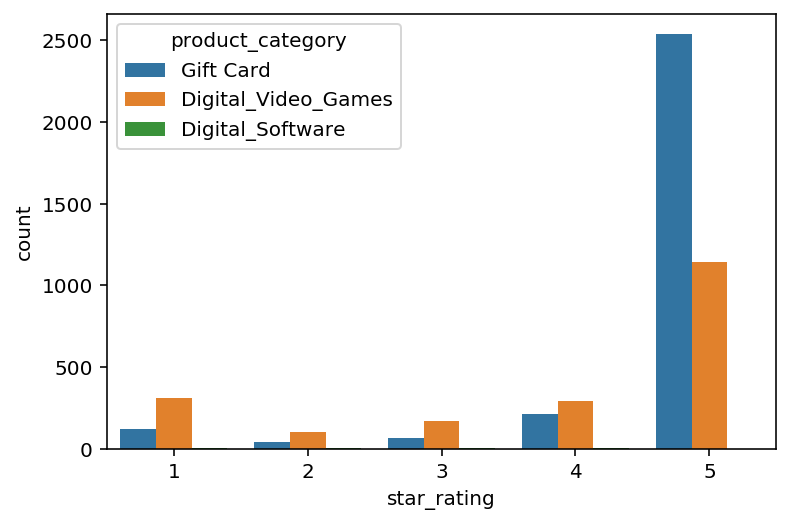

In [6]:
import seaborn as sns

sns.countplot(data=df, x="star_rating", hue="product_category")

### Upload the data

In [7]:
!mkdir -p ./transformed/

path = "./amazon_reviews_us_giftcards_software_videogames.csv"
df.to_csv(path, index=False, header=True)

data_s3_uri = sess.upload_data(bucket=bucket, key_prefix="bias/transformed", path=path)
data_s3_uri

's3://sagemaker-us-east-1-117859797117/bias/transformed/amazon_reviews_us_giftcards_software_videogames.csv'

# Analyze bias

In [8]:
from sagemaker import clarify

bias_s3_prefix = "bias/generated_bias_report"
bias_report_output_path = "s3://{}/{}/data".format(bucket, bias_s3_prefix)

data_config = clarify.DataConfig(
    s3_data_input_path=data_s3_uri,
    s3_output_path=bias_report_output_path,
    label="star_rating",
    headers=df.columns.to_list(),
    dataset_type="text/csv",
)

### Setup `BiasConfig`
SageMaker Clarify also needs the sensitive columns (`facets`) and the desirable outcomes (`label_values_or_threshold`).

We specify this information in the `BiasConfig` API. Here that the positive outcome is `star_rating==5` and `star_rating==4`.  `product_category` is the facet that we analyze in this run.

In [9]:
bias_config = clarify.BiasConfig(
    label_values_or_threshold=[5, 4], facet_name="product_category", group_name="product_category"
)

### Setup SageMaker Clarify Processing Job

In [10]:
processor = clarify.SageMakerClarifyProcessor(
    role=role, instance_count=1, instance_type="ml.m5.xlarge", sagemaker_session=sess
)

### Run Processing Job

In [11]:
processor.run_pre_training_bias(
    data_config=data_config, data_bias_config=bias_config, methods="all", wait=False, logs=False
)


Job Name:  Clarify-Pretraining-Bias-2021-04-12-15-35-14-802
Inputs:  [{'InputName': 'dataset', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-east-1-117859797117/bias/transformed/amazon_reviews_us_giftcards_software_videogames.csv', 'LocalPath': '/opt/ml/processing/input/data', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'analysis_config', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-east-1-117859797117/bias/generated_bias_report/data/analysis_config.json', 'LocalPath': '/opt/ml/processing/input/config', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}]
Outputs:  [{'OutputName': 'analysis_result', 'AppManaged': False, 'S3Output': {'S3Uri': 's3://sagemaker-us-east-1-117859797117/bias/generated_bias_report/data', 'LocalPath': '/opt/ml/processing/output', 'S3UploadMode': 'EndOfJob'}}]


In [12]:
bias_processing_job_name = processor.latest_job.job_name
print(bias_processing_job_name)

Clarify-Pretraining-Bias-2021-04-12-15-35-14-802


In [13]:
from IPython.core.display import display, HTML

display(
    HTML(
        '<b>Review <a target="blank" href="https://console.aws.amazon.com/sagemaker/home?region={}#/processing-jobs/{}">Processing Job</a></b>'.format(
            region, bias_processing_job_name
        )
    )
)

In [14]:
from IPython.core.display import display, HTML

display(
    HTML(
        '<b>Review <a target="blank" href="https://console.aws.amazon.com/cloudwatch/home?region={}#logStream:group=/aws/sagemaker/ProcessingJobs;prefix={};streamFilter=typeLogStreamPrefix">CloudWatch Logs</a> After About 5 Minutes</b>'.format(
            region, bias_processing_job_name
        )
    )
)

In [15]:
from IPython.core.display import display, HTML

display(
    HTML(
        '<b>Review <a target="blank" href="https://s3.console.aws.amazon.com/s3/buckets/{}?region={}&prefix={}/">S3 Output Data</a> After The Processing Job Has Completed</b>'.format(
            bucket, region, bias_s3_prefix
        )
    )
)

In [16]:
running_processor = sagemaker.processing.ProcessingJob.from_processing_name(
    processing_job_name=bias_processing_job_name, sagemaker_session=sess
)

### _This cell will take approximately 5-10 minutes to run._

In [17]:
%%time

running_processor.wait(logs=False)

....................................................!CPU times: user 243 ms, sys: 12 ms, total: 255 ms
Wall time: 4min 21s


### View bias report

In [18]:
!aws s3 ls $bias_report_output_path/

2021-04-12 15:39:40       6132 analysis.json
2021-04-12 15:35:15        547 analysis_config.json
2021-04-12 15:39:40     276966 report.html
2021-04-12 15:39:40       5513 report.ipynb
2021-04-12 15:39:40      36754 report.pdf


In [19]:
!aws s3 cp --recursive $bias_report_output_path ./generated_bias_report/data/

download: s3://sagemaker-us-east-1-117859797117/bias/generated_bias_report/data/analysis_config.json to generated_bias_report/data/analysis_config.json
download: s3://sagemaker-us-east-1-117859797117/bias/generated_bias_report/data/report.pdf to generated_bias_report/data/report.pdf
download: s3://sagemaker-us-east-1-117859797117/bias/generated_bias_report/data/analysis.json to generated_bias_report/data/analysis.json
download: s3://sagemaker-us-east-1-117859797117/bias/generated_bias_report/data/report.ipynb to generated_bias_report/data/report.ipynb
download: s3://sagemaker-us-east-1-117859797117/bias/generated_bias_report/data/report.html to generated_bias_report/data/report.html


In [20]:
from IPython.core.display import display, HTML

display(
    HTML('<b>Review <a target="blank" href="./generated_bias_report/data/report.html">Unbalanced Bias Report</a></b>')
)

# Balance the dataset by `product_category` and `star_rating`

In [21]:
df_group_by = df.groupby(["product_category", "star_rating"])
df_balanced_data = df_group_by.apply(lambda x: x.sample(df_group_by.size().min()).reset_index(drop=True))

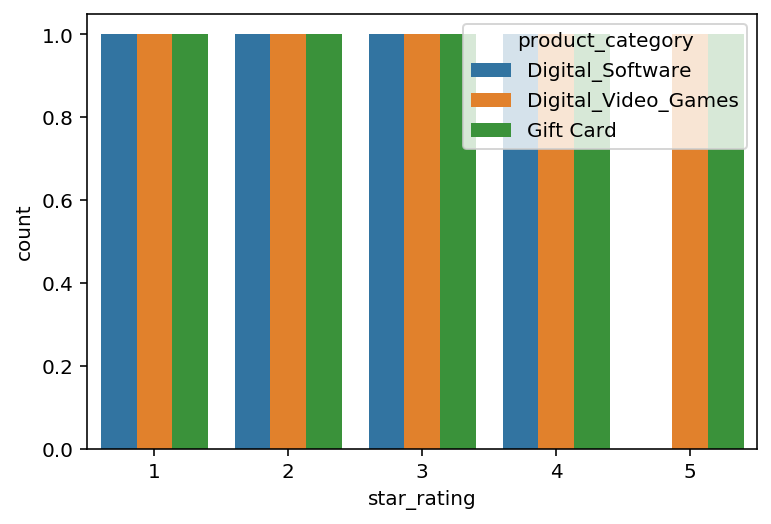

In [22]:
import seaborn as sns

sns.countplot(data=df_balanced_data, x="star_rating", hue="product_category")

# Analyze bias on balanced dataset with SageMaker Clarify

In [23]:
path_balanced = "./amazon_reviews_us_giftcards_software_videogames_balanced.csv"
df_balanced_data.to_csv(path_balanced, index=False, header=True)

balanced_data_s3_uri = sess.upload_data(bucket=bucket, key_prefix="bias/data_balanced", path=path_balanced)
balanced_data_s3_uri

's3://sagemaker-us-east-1-117859797117/bias/data_balanced/amazon_reviews_us_giftcards_software_videogames_balanced.csv'

In [24]:
from sagemaker import clarify

bias_s3_prefix = "bias/generated_bias_report"
bias_report_balanced_output_path = "s3://{}/{}/data_balanced".format(bucket, bias_s3_prefix)

balanced_data_config = clarify.DataConfig(
    s3_data_input_path=balanced_data_s3_uri,
    s3_output_path=bias_report_balanced_output_path,
    label="star_rating",
    headers=df_balanced_data.columns.to_list(),
    dataset_type="text/csv",
)

### Setup `BiasConfig`
SageMaker Clarify also needs the sensitive columns (`facets`) and the desirable outcomes (`label_values_or_threshold`).

We specify this information in the `BiasConfig` API. Here that the positive outcome is `star_rating==5` and `star_rating==4`.  `product_category` is the facet that we analyze in this run.

In [25]:
bias_config = clarify.BiasConfig(
    label_values_or_threshold=[5, 4], facet_name="product_category", group_name="product_category"
)

### Setup SageMaker Clarify Processing Job

In [26]:
processor = clarify.SageMakerClarifyProcessor(
    role=role, instance_count=1, instance_type="ml.m5.xlarge", sagemaker_session=sess
)

In [27]:
processor.run_pre_training_bias(
    data_config=balanced_data_config, data_bias_config=bias_config, methods="all", wait=False, logs=False
)


Job Name:  Clarify-Pretraining-Bias-2021-04-12-15-45-28-858
Inputs:  [{'InputName': 'dataset', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-east-1-117859797117/bias/data_balanced/amazon_reviews_us_giftcards_software_videogames_balanced.csv', 'LocalPath': '/opt/ml/processing/input/data', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'analysis_config', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-east-1-117859797117/bias/generated_bias_report/data_balanced/analysis_config.json', 'LocalPath': '/opt/ml/processing/input/config', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}]
Outputs:  [{'OutputName': 'analysis_result', 'AppManaged': False, 'S3Output': {'S3Uri': 's3://sagemaker-us-east-1-117859797117/bias/generated_bias_report/data_balanced', 'LocalPath': '/opt/ml/processing/output', 'S3Uplo

In [28]:
balanced_bias_processing_job_name = processor.latest_job.job_name
print(balanced_bias_processing_job_name)

Clarify-Pretraining-Bias-2021-04-12-15-45-28-858


In [29]:
from IPython.core.display import display, HTML

display(
    HTML(
        '<b>Review <a target="blank" href="https://console.aws.amazon.com/sagemaker/home?region={}#/processing-jobs/{}">Processing Job</a></b>'.format(
            region, balanced_bias_processing_job_name
        )
    )
)

In [30]:
from IPython.core.display import display, HTML

display(
    HTML(
        '<b>Review <a target="blank" href="https://console.aws.amazon.com/cloudwatch/home?region={}#logStream:group=/aws/sagemaker/ProcessingJobs;prefix={};streamFilter=typeLogStreamPrefix">CloudWatch Logs</a> After About 5 Minutes</b>'.format(
            region, balanced_bias_processing_job_name
        )
    )
)

In [31]:
from IPython.core.display import display, HTML

display(
    HTML(
        '<b>Review <a target="blank" href="https://s3.console.aws.amazon.com/s3/buckets/{}?region={}&prefix={}/">S3 Output Data</a> After The Processing Job Has Completed</b>'.format(
            bucket, region, bias_s3_prefix
        )
    )
)

In [32]:
running_processor = sagemaker.processing.ProcessingJob.from_processing_name(
    processing_job_name=balanced_bias_processing_job_name, sagemaker_session=sess
)

### _This cell will take approximately 5-10 minutes to run._

In [33]:
%%time

running_processor.wait(logs=False)

........................................................................................................................................!CPU times: user 611 ms, sys: 24.1 ms, total: 635 ms
Wall time: 11min 23s


### Analyze balanced bias report
Note that the class imbalance metric is equal across all product categories for the target label.

Download generated bias report from S3

In [34]:
!aws s3 ls $bias_report_balanced_output_path/

2021-04-12 15:56:54       6190 analysis.json
2021-04-12 15:45:30        547 analysis_config.json
2021-04-12 15:56:54     276980 report.html
2021-04-12 15:56:54       5527 report.ipynb
2021-04-12 15:56:54      36698 report.pdf


In [39]:
!aws s3 cp --recursive $bias_report_balanced_output_path ./generated_bias_report/data_balanced/

download: s3://sagemaker-us-east-1-117859797117/bias/generated_bias_report/data_balanced/analysis.json to generated_bias_report/data_balanced/analysis.json
download: s3://sagemaker-us-east-1-117859797117/bias/generated_bias_report/data_balanced/analysis_config.json to generated_bias_report/data_balanced/analysis_config.json
download: s3://sagemaker-us-east-1-117859797117/bias/generated_bias_report/data_balanced/report.ipynb to generated_bias_report/data_balanced/report.ipynb
download: s3://sagemaker-us-east-1-117859797117/bias/generated_bias_report/data_balanced/report.pdf to generated_bias_report/data_balanced/report.pdf
download: s3://sagemaker-us-east-1-117859797117/bias/generated_bias_report/data_balanced/report.html to generated_bias_report/data_balanced/report.html


In [40]:
from IPython.core.display import display, HTML

display(
    HTML(
        '<b>Review <a target="blank" href="./generated_bias_report/data_balanced/report.html">Balanced Bias Report</a></b>'
    )
)

# Release Resources